# Generative Adversarial Network using PyTorch
## Vanilla GAN implementation
## Rahul Bhadani
## CPE 490 590 Machine Learning for Engineering Applications

In [13]:
# !pip3 install torch torchvision torchaudio
# !pip install pytorch-lightning


In [15]:
# Importing necessary libraries
import os

# PyTorch is an open source machine learning library based on the Torch library
import torch
# torchvision is a library for PyTorch that provides access to popular datasets, model architectures, and image transformations for computer vision.
import torchvision
# torch.nn provides classes to create and manipulate neural network architectures
import torch.nn as nn
# torch.optim is a package implementing various optimization algorithms
import torch.optim as optim
# torch.nn.functional contains functions that do not have any parameters
import torch.nn.functional as F
# torchvision.datasets provides access to many datasets
import torchvision.datasets as datasets
# torchvision.transforms provides common image transformations
import torchvision.transforms as transforms
# torch.utils.data provides utilities for loading and manipulating data
from torch.utils.data import DataLoader, random_split
# torchvision.datasets.MNIST provides the MNIST dataset
from torchvision.datasets import MNIST

# matplotlib.pyplot is a collection of functions that provide a MATLAB-like interface for making plots
import matplotlib.pyplot as plt

# PyTorch Lightning is a lightweight PyTorch wrapper for high-performance AI research
import pytorch_lightning as pl

# Setting a seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Setting the batch size for training
BATCH_SIZE=128
# Checking the number of available GPUs and setting it to 1 if there is at least one available
AVAIL_GPUS = min(1, torch.cuda.device_count())
# Setting the number of workers for data loading to half the number of CPU cores
NUM_WORKERS=int(os.cpu_count() / 2)


In [14]:
AVAIL_GPUS

1

In [16]:
"""
This class, MNISTDataModule, is a custom PyTorch Lightning DataModule for the MNIST dataset. It defines how to download the dataset (prepare_data), how to split it into training, validation, and test sets (setup), and how to load these datasets into DataLoaders (train_dataloader, val_dataloader, test_dataloader). The DataLoaders are used to iterate over the datasets in batches during training, validation, and testing.
"""

# Defining a PyTorch Lightning DataModule for the MNIST dataset
class MNISTDataModule(pl.LightningDataModule):
    # Constructor for the DataModule
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        # Setting the directory where the data is or will be downloaded
        self.data_dir = data_dir
        # Setting the batch size for the DataLoader
        self.batch_size = batch_size
        # Setting the number of workers for the DataLoader
        self.num_workers = num_workers

        # Defining the transformations to be applied to the images
        self.transform = transforms.Compose(
            [
                # Convert image to PyTorch tensor
                transforms.ToTensor(),
                # Normalize the image with mean and standard deviation
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    # Method to prepare the data, downloads the data
    def prepare_data(self):
        # Download the training data
        MNIST(self.data_dir, train=True, download=True)
        # Download the test data
        MNIST(self.data_dir, train=False, download=True)

    # Method to setup the data for different stages
    def setup(self, stage=None):
        # Assign train/val datasets for the fit stage
        if stage == "fit" or stage is None:
            # Load the full training dataset
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            # Split the full dataset into training and validation datasets
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for the test stage
        if stage == "test" or stage is None:
            # Load the test dataset
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    # Method to load the training data into a DataLoader
    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    # Method to load the validation data into a DataLoader
    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    # Method to load the test data into a DataLoader
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)


In [21]:
# Detective: fake or no fake -> 1 output [0, 1]
# This is a Discriminator class for a Generative Adversarial Network (GAN).
# The Discriminator is a simple Convolutional Neural Network (CNN) that acts as a "detective" to determine if an input image is real or fake.

"""
This class defines a simple CNN-based discriminator for a GAN. The discriminator takes in an image (real or generated by the GAN’s generator) and outputs a single value in the range [0, 1], representing the discriminator’s belief that the input image is real (1) or fake (0). The network architecture consists of two convolutional layers, each followed by max pooling and ReLU activation, and two fully connected layers. Dropout is applied after the second convolutional layer and the first fully connected layer for regularization. The output of the network is passed through a sigmoid activation function to constrain it to the range [0, 1].
"""
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the layers of the CNN
        # First convolutional layer with 1 input channel and 10 output channels
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # Second convolutional layer with 10 input channels and 20 output channels
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # Dropout layer to prevent overfitting
        self.conv2_drop = nn.Dropout2d()
        # First fully connected layer with 320 input features and 50 output features
        self.fc1 = nn.Linear(320, 50)
        # Second fully connected layer with 50 input features and 1 output feature
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        # Apply the first convolutional layer followed by max pooling and ReLU activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Apply the second convolutional layer followed by dropout, max pooling, and ReLU activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the fully connected layers
        x = x.view(-1, 320)
        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        # Apply dropout for regularization
        x = F.dropout(x, training=self.training)
        # Apply the second fully connected layer
        x = self.fc2(x)
        # Apply sigmoid activation to get the output in the range [0, 1]
        return torch.sigmoid(x)


In [22]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
# This is a Generator class for a Generative Adversarial Network (GAN).
# The Generator is a simple Convolutional Neural Network (CNN) that generates "fake" images from a latent space.
"""
This class defines a simple CNN-based generator for a GAN. The generator takes in a point in the latent space and outputs a “fake” image. The network architecture consists of a linear layer, two transposed convolutional layers (for upsampling), and a final convolutional layer. Each layer (except the final convolutional layer) is followed by a ReLU activation function. The output of the network is an image with the same dimensions as the real images that the discriminator will be comparing against. The goal of the generator is to produce images that the discriminator cannot distinguish from real images.

"""
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Define the layers of the CNN
        # First linear layer that maps the input from the latent space to a feature map
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        # First transposed convolutional layer (upsampling) with 64 input channels and 32 output channels
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        # Second transposed convolutional layer (upsampling) with 32 input channels and 16 output channels
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        # Convolutional layer to get the final image with 1 output channel
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]

    def forward(self, x):
        # Pass the input through the first linear layer and apply ReLU activation
        x = self.lin1(x)
        x = F.relu(x)
        # Reshape the tensor for the convolutional layers
        x = x.view(-1, 64, 7, 7)  #256

        # Pass the tensor through the first transposed convolutional layer and apply ReLU activation
        x = self.ct1(x)
        x = F.relu(x)

        # Pass the tensor through the second transposed convolutional layer and apply ReLU activation
        x = self.ct2(x)
        x = F.relu(x)

        # Pass the tensor through the final convolutional layer to get the generated image
        return self.conv(x)


Epoch [0/5], d_loss: 0.06727762520313263, g_loss: 4.082671642303467


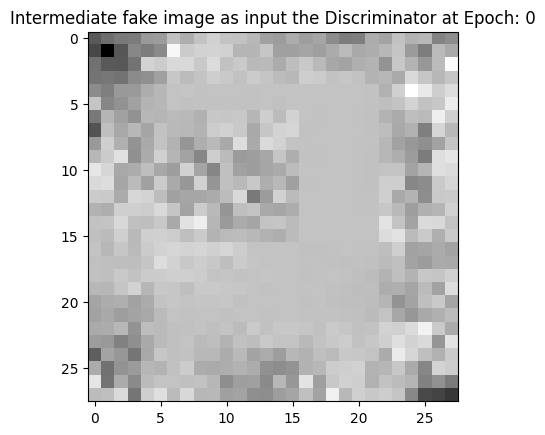

Epoch [1/5], d_loss: 0.03731488436460495, g_loss: 8.13955307006836


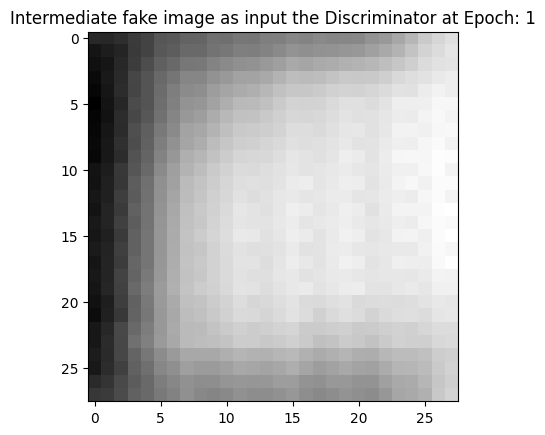

Epoch [2/5], d_loss: 0.5674701929092407, g_loss: 1.9908709526062012


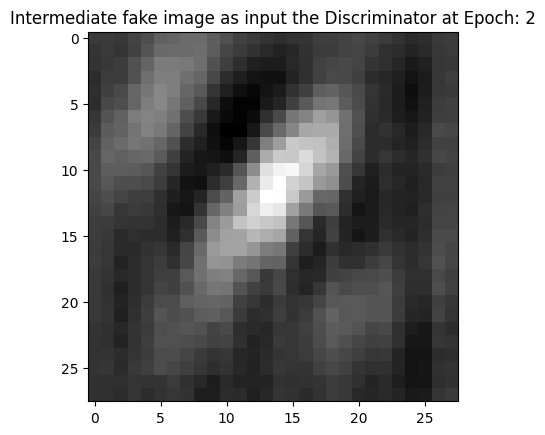

Epoch [3/5], d_loss: 0.9633795022964478, g_loss: 1.630964994430542


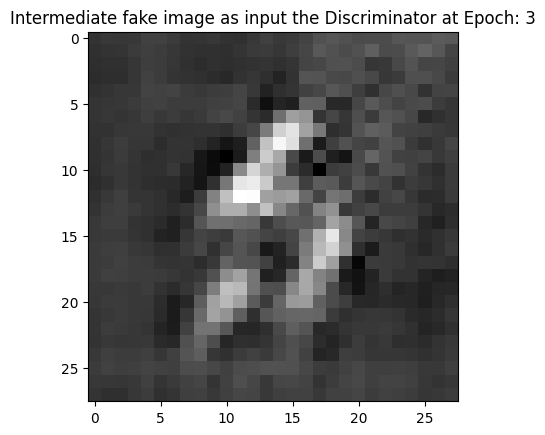

Epoch [4/5], d_loss: 0.71787428855896, g_loss: 1.7413617372512817


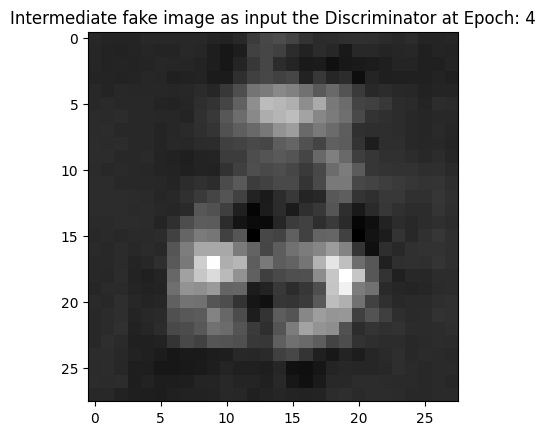

In [23]:
import matplotlib.pyplot as plt

# Instantiate the datamodule, generator, and discriminator
data_module = MNISTDataModule()
data_module.prepare_data()  # Download the data
data_module.setup('fit')  # Prepare the data for the 'fit' stage (training)
discriminator = Discriminator()  # Initialize the discriminator
generator = Generator(latent_dim=100)  # Initialize the generator with a latent dimension of 100

# Define the loss function and the optimizers
criterion = nn.BCELoss()  # Binary Cross Entropy loss function
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)  # Adam optimizer for the discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)  # Adam optimizer for the generator

# Define the training loop
N_EPOCHS = 5  # Number of epochs
for epoch in range(N_EPOCHS):  # Loop over each epoch
    for real_images, _ in data_module.train_dataloader():  # Loop over each batch of real images
        batch_size = real_images.size(0)  # Get the batch size

        # Train the discriminator with real images
        real_labels = torch.ones(batch_size, 1)  # Labels for real images are 1
        outputs = discriminator(real_images)  # Pass the real images through the discriminator
        d_loss_real = criterion(outputs, real_labels)  # Compute the loss for the real images
        real_score = outputs  # Score for the real images

        # Train the discriminator with fake images
        z = torch.randn(batch_size, 100)  # Generate random noise as input for the generator
        fake_images = generator(z)  # Generate fake images from the noise
        fake_labels = torch.zeros(batch_size, 1)  # Labels for fake images are 0
        outputs = discriminator(fake_images)  # Pass the fake images through the discriminator
        d_loss_fake = criterion(outputs, fake_labels)  # Compute the loss for the fake images
        fake_score = outputs  # Score for the fake images

        # Backprop and optimize the discriminator
        d_loss = d_loss_real + d_loss_fake  # Total loss is the sum of the losses for real and fake images
        discriminator.zero_grad()  # Zero the gradients of the discriminator
        d_loss.backward()  # Perform backpropagation
        optimizer_D.step()  # Update the weights of the discriminator

        # Train the generator
        z = torch.randn(batch_size, 100)  # Generate random noise as input for the generator
        fake_images = generator(z)  # Generate fake images from the noise
        labels = torch.ones(batch_size, 1)  # The generator wants the discriminator to output 1 for fake images
        outputs = discriminator(fake_images)  # Pass the fake images through the discriminator

        # Backprop and optimize the generator
        g_loss = criterion(outputs, labels)  # Compute the loss for the generator
        generator.zero_grad()  # Zero the gradients of the generator
        g_loss.backward()  # Perform backpropagation
        optimizer_G.step()  # Update the weights of the generator

    print(f'Epoch [{epoch}/{N_EPOCHS}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')  # Print the losses for this epoch

    # Display a fake image after each epoch
    plt.imshow(fake_images[0].detach().cpu().numpy().reshape(28, 28), cmap='gray')  # Display the first fake image
    plt.title('Intermediate fake image as input the Discriminator at Epoch: {}'.format(epoch))  # Set the title of the plot
    plt.show()  # Show the plot

# Save the trained generator
torch.save(generator.state_dict(), 'generator.pth')  # Save the state of the generator


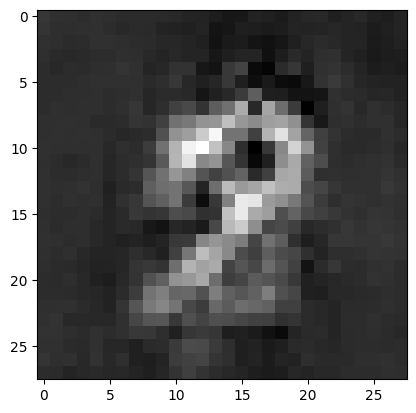

In [24]:
import matplotlib.pyplot as plt

# Assume that the generator has been trained and saved
generator = Generator(latent_dim=100)
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

# Generate a batch of "fake" images
z = torch.randn(1, 100)  # Change 1 to any number to generate that many images
with torch.no_grad():
    fake_images = generator(z)

# Convert the tensor to a NumPy array and reshape it for display
fake_image = fake_images[0].detach().cpu().numpy().reshape(28, 28)

# Display the fake image
plt.imshow(fake_image, cmap='gray')
plt.show()
